# Prelude to creating performance curves

**CODE FOR CREATING PERFORMANCE CURVES HAS BEEN MOVED TO performance_curves.py in mm_interpret project.**

The outputs of `performance_curves.py` are:

* `siminout_path/{perf_curve_scenarios_suffix}_obflow06_metainputs_pc.csv` 
* `matrix_data_path/X_performance_curves_{perf_curve_scenarios_suffix}.csv`

For example: `exp11d_obflow06_metainputs_pc,csv`

Here's the code from start of `main` in `performance_curves.py`. Yes, that code should get moved into a CLI.

```python
        mm_experiment_suffix = "exp11"
        perf_curve_scenarios_suffix = "exp11d"
        # Path to scenario yaml file created by scenario_grid.py
        path_scenario_grid_yaml = Path("mm_use", f"scenario_grid_{perf_curve_scenarios_suffix}.yaml")
        path_scenario_csv = Path("mm_use", f"X_performance_curves_{perf_curve_scenarios_suffix}.csv")
        siminout_path = Path("data/siminout")
        matrix_data_path = Path("data")
```

The key input is the YAML file specifying the scenario grid. Also, note that performance curves may be created before the scenarios have been simulated. In fact, they may never get simulated unless we want to compare predicted outputs to simulation outputs.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import pickle
import itertools
import yaml

In [4]:
!which python

/home/mark/anaconda3/envs/analytics/bin/python


In [5]:
!python --version

Python 3.8.8


**Make sure kernel is set to [conda env:analytics]. Click in upper right to select kernel. Seems like this did not get set when notebook opened even if analytics is active environment.**

In [6]:
import sys;sys.executable

'/home/mark/anaconda3/envs/analytics/bin/python'

In [7]:
!conda list | grep 'qng'

qng                       0.1.0                     dev_0    <develop>


In [8]:
!conda list | grep 'obnetwork'

obnetwork                 0.1.0                     dev_0    <develop>


In [9]:
from obnetwork import obnetwork
from qng import qng
from dataprep import qng_approx_from_inputs
from mmfitting import crossval_summarize_mm

In [10]:
%matplotlib inline

## Data reading and prep

In [11]:
experiment = "exp11"
data_path = Path("data")
output_path = Path("output")
figures_path = Path("output", "figures")
raw_data_path = Path("data", "siminout")
pickle_filename = f"ldr_results_{experiment}.pkl"

In [12]:
# X matrices
X_ldr_noq = pd.read_csv(Path(data_path, f'X_ldr_noq_{experiment}.csv'), index_col=0)
X_ldr_basicq = pd.read_csv(Path(data_path, f'X_ldr_basicq_{experiment}.csv'), index_col=0)
X_ldr_q = pd.read_csv(Path(data_path, f'X_ldr_q_{experiment}.csv'), index_col=0)

X_ldr_occ_mean_onlyq = pd.read_csv(Path(data_path, f'X_ldr_occmean_onlyq_{experiment}.csv'), index_col=0)
X_ldr_occ_p95_onlyq = pd.read_csv(Path(data_path, f'X_ldr_occp95_onlyq_{experiment}.csv'), index_col=0)
X_ldr_prob_blockedby_pp_onlyq = pd.read_csv(Path(data_path, f'X_ldr_prob_blockedby_pp_onlyq_{experiment}.csv'),
                                            index_col=0)
X_ldr_condmeantime_blockedby_pp_onlyq = \
    pd.read_csv(Path(data_path, f'X_ldr_condmeantime_blockedby_pp_onlyq_{experiment}.csv'), index_col=0)

# y vectors
y_ldr_occ_mean = pd.read_csv(Path(data_path, f'y_ldr_occ_mean_{experiment}.csv'), index_col=0, squeeze=True)
y_ldr_occ_p95 = pd.read_csv(Path(data_path, f'y_ldr_occ_p95_{experiment}.csv'), index_col=0, squeeze=True)
y_prob_blockedby_pp = \
    pd.read_csv(Path(data_path, f'y_prob_blockedby_pp_{experiment}.csv'), index_col=0, squeeze=True)
y_condmeantime_blockedby_pp = \
    pd.read_csv(Path(data_path, f'y_condmeantime_blockedby_pp_{experiment}.csv'), index_col=0, squeeze=True)

In [13]:
X_ldr_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 1 to 135
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   arrival_rate                       135 non-null    float64
 1   mean_los_obs                       135 non-null    float64
 2   mean_los_ldr                       135 non-null    int64  
 3   cap_ldr                            135 non-null    int64  
 4   mean_los_pp                        135 non-null    float64
 5   c_sect_prob                        135 non-null    float64
 6   cap_pp                             135 non-null    int64  
 7   load_ldr                           135 non-null    float64
 8   rho_ldr                            135 non-null    float64
 9   load_pp                            135 non-null    float64
 10  rho_pp                             135 non-null    float64
 11  prob_blockedby_pp_approx           135 non-null    float64

In [14]:
X_ldr_q.head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,load_pp,...,prob_blockedby_pp_approx,condmeantime_blockedby_pp_approx,prob_blockedby_ldr_approx,condmeantime_blockedby_ldr_approx,pp_cv2_svctime,ldr_eff_load,ldr_eff_sqrtload,ldr_effmean_svctime_approx,sqrt_load_ldr,sqrt_load_pp
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.114155,2.4,12,4,52.8,0.2,12,1.369863,0.342466,6.027397,...,0.023199,6.526361,0.055086,3.778654,0.16219,1.359928,1.166160,11.912974,1.170411,2.455076
2,0.114155,2.4,12,4,52.8,0.2,10,1.369863,0.342466,6.027397,...,0.103794,8.966441,0.063771,4.035329,0.16219,1.425479,1.193934,12.487194,1.170411,2.455076
3,0.114155,2.4,12,4,52.8,0.2,9,1.369863,0.342466,6.027397,...,0.200133,11.480445,0.080531,4.507946,0.16219,1.538249,1.240262,13.475060,1.170411,2.455076
4,0.114155,2.4,12,3,52.8,0.2,12,1.369863,0.456621,6.027397,...,0.023199,6.526361,0.165820,5.224348,0.16219,1.284797,1.133489,11.254823,1.170411,2.455076
5,0.114155,2.4,12,3,52.8,0.2,10,1.369863,0.456621,6.027397,...,0.103794,8.966441,0.182374,5.596022,0.16219,1.338352,1.156871,11.723960,1.170411,2.455076


In [15]:
X_ldr_q_cols = X_ldr_q.columns.tolist()

In [16]:
X_ldr_q_cols

['arrival_rate',
 'mean_los_obs',
 'mean_los_ldr',
 'cap_ldr',
 'mean_los_pp',
 'c_sect_prob',
 'cap_pp',
 'load_ldr',
 'rho_ldr',
 'load_pp',
 'rho_pp',
 'prob_blockedby_pp_approx',
 'condmeantime_blockedby_pp_approx',
 'prob_blockedby_ldr_approx',
 'condmeantime_blockedby_ldr_approx',
 'pp_cv2_svctime',
 'ldr_eff_load',
 'ldr_eff_sqrtload',
 'ldr_effmean_svctime_approx',
 'sqrt_load_ldr',
 'sqrt_load_pp']

### Creating scenario dataframe to drive graph

In [17]:
arrival_rate = np.linspace(5, 15, 11) / 24
mean_los_obs = np.atleast_1d(2.4)
mean_los_ldr = np.atleast_1d(12.0)
cap_ldr = np.atleast_1d(16)
cap_pp = np.atleast_1d(36)
mean_los_pp_noc = np.atleast_1d(48.0)
mean_los_pp_c = np.atleast_1d(72.0)
c_sect_prob = np.atleast_1d(0.25)

num_erlang_stages_obs = np.atleast_1d(1)
num_erlang_stages_ldr = np.atleast_1d(2)
num_erlang_stages_pp = np.atleast_1d(8)

In [19]:
input_scenarios = [scn for scn in itertools.product(
    arrival_rate, mean_los_obs, mean_los_ldr, cap_ldr,
    mean_los_pp_noc, mean_los_pp_c, c_sect_prob, cap_pp,
    num_erlang_stages_obs, num_erlang_stages_ldr, num_erlang_stages_pp)]

cols = ['arrival_rate', 'mean_los_obs', 'mean_los_ldr', 'cap_ldr',
        'mean_los_pp_noc', 'mean_los_pp_c', 'c_sect_prob', 'cap_pp',
        'num_erlang_stages_obs', 'num_erlang_stages_ldr', 'num_erlang_stages_pp']

scenarios_io_df = pd.DataFrame(input_scenarios, columns=cols)

scenarios_io_df.set_index(np.arange(1, 12), inplace=True)
scenarios_io_df.index.name = 'scenario'


In [20]:
scenarios_io_df

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp_noc,mean_los_pp_c,c_sect_prob,cap_pp,num_erlang_stages_obs,num_erlang_stages_ldr,num_erlang_stages_pp
scenario,,,,,,,,,,,
1,0.208333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
2,0.250000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
3,0.291667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
4,0.333333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
5,0.375000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
6,0.416667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
7,0.458333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
8,0.500000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
9,0.541667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8


In [21]:
scenarios_io_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   arrival_rate           11 non-null     float64
 1   mean_los_obs           11 non-null     float64
 2   mean_los_ldr           11 non-null     float64
 3   cap_ldr                11 non-null     int64  
 4   mean_los_pp_noc        11 non-null     float64
 5   mean_los_pp_c          11 non-null     float64
 6   c_sect_prob            11 non-null     float64
 7   cap_pp                 11 non-null     int64  
 8   num_erlang_stages_obs  11 non-null     int64  
 9   num_erlang_stages_ldr  11 non-null     int64  
 10  num_erlang_stages_pp   11 non-null     int64  
dtypes: float64(6), int64(5)
memory usage: 1.0 KB


In [22]:
scenarios_io_df.head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp_noc,mean_los_pp_c,c_sect_prob,cap_pp,num_erlang_stages_obs,num_erlang_stages_ldr,num_erlang_stages_pp
scenario,,,,,,,,,,,
1,0.208333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
2,0.250000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
3,0.291667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
4,0.333333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8
5,0.375000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8


Compute overall PP mean los

In [23]:
scenarios_io_df['mean_los_pp'] = scenarios_io_df['c_sect_prob'] * scenarios_io_df['mean_los_pp_c'] + (1 - scenarios_io_df['c_sect_prob']) * scenarios_io_df['mean_los_pp_noc']

Compute load and rho related terms.

In [24]:
scenarios_io_df['load_ldr'] = scenarios_io_df['arrival_rate'] * scenarios_io_df['mean_los_ldr']
scenarios_io_df['rho_ldr'] = scenarios_io_df['load_ldr'] / scenarios_io_df['cap_ldr']

scenarios_io_df['load_pp'] = scenarios_io_df['arrival_rate'] * scenarios_io_df['mean_los_pp']
scenarios_io_df['rho_pp'] = scenarios_io_df['load_pp'] / scenarios_io_df['cap_pp']

scenarios_io_df['sqrt_load_ldr'] = np.sqrt(scenarios_io_df['load_ldr'])
scenarios_io_df['sqrt_load_pp'] = np.sqrt(scenarios_io_df['load_pp'])

Computer cv2 of PP service time distribution

In [25]:
mean = (72 * 0.2 + 48 * 0.8)
m2 = qng.hyper_erlang_moment([1 / 48, 1 / 72], [8, 8], [.8, .2], 2)
var = m2 - mean ** 2
cv2 = var / mean ** 2
print(f'mean={mean}, m2={m2}, var={var}, cv2={cv2}')

mean=52.800000000000004, m2=3240.000000000001, var=452.1600000000003, cv2=0.16219008264462817


In [26]:
np.dot([48, 72], [.8, .2])

52.800000000000004

In [27]:
def hyper_erlang_cv2(means, stages, probs):
    mean = np.dot(means, probs)
    rates = [1 / m for m in means]
    m2 = qng.hyper_erlang_moment(rates, stages, probs, 2)
    var = m2 - mean ** 2
    cv2 = var / mean ** 2
    return cv2

In [28]:
hyper_erlang_cv2([48, 72], [8, 8], [.8, .2])

0.16219008264462817

In [29]:
scenarios_io_df['pp_cv2_svctime'] = scenarios_io_df.apply(lambda x: hyper_erlang_cv2(
    [x.mean_los_pp_noc, x.mean_los_pp_c], [x.num_erlang_stages_pp, x.num_erlang_stages_pp],
     [1 - x.c_sect_prob, x.c_sect_prob]), axis=1)

In [30]:
scenarios_io_df.head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp_noc,mean_los_pp_c,c_sect_prob,cap_pp,num_erlang_stages_obs,num_erlang_stages_ldr,num_erlang_stages_pp,mean_los_pp,load_ldr,rho_ldr,load_pp,rho_pp,sqrt_load_ldr,sqrt_load_pp,pp_cv2_svctime
scenario,,,,,,,,,,,,,,,,,,,
1,0.208333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8,54.0,2.5,0.15625,11.25,0.3125,1.581139,3.354102,0.166667
2,0.250000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8,54.0,3.0,0.18750,13.50,0.3750,1.732051,3.674235,0.166667
3,0.291667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8,54.0,3.5,0.21875,15.75,0.4375,1.870829,3.968627,0.166667
4,0.333333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8,54.0,4.0,0.25000,18.00,0.5000,2.000000,4.242641,0.166667
5,0.375000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,8,54.0,4.5,0.28125,20.25,0.5625,2.121320,4.500000,0.166667


In [31]:
scenarios_io_df['ldr_cv2_svctime'] = scenarios_io_df.apply(lambda x: 1 / x.num_erlang_stages_ldr, axis=1)

In [32]:
scenarios_io_df['prob_blockedby_pp_approx'] = scenarios_io_df.apply(lambda x: obnetwork.prob_blockedby_pp_hat(
    x.arrival_rate, x.mean_los_pp, x.cap_pp, x.pp_cv2_svctime), axis=1)

In [33]:
scenarios_io_df['condmeantime_blockedby_pp_approx'] = scenarios_io_df.apply(lambda x: obnetwork.condmeantime_blockedby_pp_hat(
    x.arrival_rate, x.mean_los_pp, x.cap_pp, x.pp_cv2_svctime), axis=1)

In [34]:
scenarios_io_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   arrival_rate                      11 non-null     float64
 1   mean_los_obs                      11 non-null     float64
 2   mean_los_ldr                      11 non-null     float64
 3   cap_ldr                           11 non-null     int64  
 4   mean_los_pp_noc                   11 non-null     float64
 5   mean_los_pp_c                     11 non-null     float64
 6   c_sect_prob                       11 non-null     float64
 7   cap_pp                            11 non-null     int64  
 8   num_erlang_stages_obs             11 non-null     int64  
 9   num_erlang_stages_ldr             11 non-null     int64  
 10  num_erlang_stages_pp              11 non-null     int64  
 11  mean_los_pp                       11 non-null     float64
 12  load_ldr  

In [35]:
scenarios_io_df['prob_blockedby_ldr_approx'] = \
    scenarios_io_df.apply(lambda x: obnetwork.obs_blockedby_ldr_hats(
        x.arrival_rate, x.c_sect_prob, x.mean_los_ldr, x.ldr_cv2_svctime, x.cap_ldr, 
    x.mean_los_pp, x.pp_cv2_svctime, x.cap_pp)[2], axis=1)

In [36]:
scenarios_io_df['condmeantime_blockedby_ldr_approx'] = \
    scenarios_io_df.apply(lambda x: obnetwork.obs_blockedby_ldr_hats(
        x.arrival_rate, x.c_sect_prob, x.mean_los_ldr, x.ldr_cv2_svctime, x.cap_ldr, 
    x.mean_los_pp, x.pp_cv2_svctime, x.cap_pp)[3], axis=1)

In [37]:
scenarios_io_df['ldr_effmean_svctime_approx'] = \
    scenarios_io_df.apply(lambda x: obnetwork.obs_blockedby_ldr_hats(
        x.arrival_rate, x.c_sect_prob, x.mean_los_ldr, x.ldr_cv2_svctime, x.cap_ldr, 
    x.mean_los_pp, x.pp_cv2_svctime, x.cap_pp)[1], axis=1)

In [38]:
scenarios_io_df['mean_los_ldr']

scenario
1     12.0
2     12.0
3     12.0
4     12.0
5     12.0
6     12.0
7     12.0
8     12.0
9     12.0
10    12.0
11    12.0
Name: mean_los_ldr, dtype: float64

In [39]:
scenarios_io_df['ldr_eff_load'] = scenarios_io_df['arrival_rate'] * scenarios_io_df['ldr_effmean_svctime_approx']

scenarios_io_df['ldr_eff_sqrtload'] = np.sqrt(scenarios_io_df['ldr_eff_load'])


Now just want the columns that exist in `X_ldr_q` to use in making predictions for the different perf measures with the various models we already fit with sklearn. In addition, we want to compare with some direct queueing approximations.

In [40]:
scenarios_io_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   arrival_rate                       11 non-null     float64
 1   mean_los_obs                       11 non-null     float64
 2   mean_los_ldr                       11 non-null     float64
 3   cap_ldr                            11 non-null     int64  
 4   mean_los_pp_noc                    11 non-null     float64
 5   mean_los_pp_c                      11 non-null     float64
 6   c_sect_prob                        11 non-null     float64
 7   cap_pp                             11 non-null     int64  
 8   num_erlang_stages_obs              11 non-null     int64  
 9   num_erlang_stages_ldr              11 non-null     int64  
 10  num_erlang_stages_pp               11 non-null     int64  
 11  mean_los_pp                        11 non-null     float64
 

Get correct columns and in correct order to match `X_ldr_q_cols`.

In [41]:
X_ldr_q_scenarios_df = scenarios_io_df.loc[:, X_ldr_q_cols]

In [42]:
X_ldr_q_scenarios_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   arrival_rate                       11 non-null     float64
 1   mean_los_obs                       11 non-null     float64
 2   mean_los_ldr                       11 non-null     float64
 3   cap_ldr                            11 non-null     int64  
 4   mean_los_pp                        11 non-null     float64
 5   c_sect_prob                        11 non-null     float64
 6   cap_pp                             11 non-null     int64  
 7   load_ldr                           11 non-null     float64
 8   rho_ldr                            11 non-null     float64
 9   load_pp                            11 non-null     float64
 10  rho_pp                             11 non-null     float64
 11  prob_blockedby_pp_approx           11 non-null     float64
 

In [43]:
X_ldr_q_scenarios_df.iloc[:,:15].head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,load_pp,rho_pp,prob_blockedby_pp_approx,condmeantime_blockedby_pp_approx,prob_blockedby_ldr_approx,condmeantime_blockedby_ldr_approx
scenario,,,,,,,,,,,,,,,
1,0.208333,2.4,12.0,16,54.0,0.25,36,2.5,0.15625,11.25,0.3125,3.530775e-09,2.576468,1.082606e-08,1.020865
2,0.250000,2.4,12.0,16,54.0,0.25,36,3.0,0.18750,13.50,0.3750,2.901516e-07,2.543231,1.260706e-07,1.022082
3,0.291667,2.4,12.0,16,54.0,0.25,36,3.5,0.21875,15.75,0.4375,8.735831e-06,2.573467,9.368191e-07,1.028503
4,0.333333,2.4,12.0,16,54.0,0.25,36,4.0,0.25000,18.00,0.5000,1.267657e-04,2.667352,5.014318e-06,1.039830
5,0.375000,2.4,12.0,16,54.0,0.25,36,4.5,0.28125,20.25,0.5625,1.059973e-03,2.834874,2.093330e-05,1.056084


In [44]:
X_ldr_q_scenarios_df.iloc[:,:15].tail()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,load_pp,rho_pp,prob_blockedby_pp_approx,condmeantime_blockedby_pp_approx,prob_blockedby_ldr_approx,condmeantime_blockedby_ldr_approx
scenario,,,,,,,,,,,,,,,
7,0.458333,2.4,12.0,16,54.0,0.25,36,5.5,0.34375,24.75,0.6875,0.022557,3.507631,0.000220,1.109343
8,0.500000,2.4,12.0,16,54.0,0.25,36,6.0,0.37500,27.00,0.7500,0.067498,4.157524,0.000642,1.160372
9,0.541667,2.4,12.0,16,54.0,0.25,36,6.5,0.40625,29.25,0.8125,0.163846,5.280711,0.002081,1.263592
10,0.583333,2.4,12.0,16,54.0,0.25,36,7.0,0.43750,31.50,0.8750,0.337411,7.575958,0.010182,1.545402
11,0.625000,2.4,12.0,16,54.0,0.25,36,7.5,0.46875,33.75,0.9375,0.610878,14.542321,0.144226,3.185299


In [45]:
X_ldr_q_scenarios_df.to_csv('data/X_ldr_q_scenarios_df.csv', index=False)

### Get fitted model results

In [46]:
unit = 'ldr'
exp = 'exp11'
with open(Path("output", f"{unit}_results_{exp}.pkl"), 'rb') as pickle_file:
    ldr_results = pickle.load(pickle_file)

In [47]:
#unit = 'pp'
#with open(Path("output", f"{unit}_results.pkl"), 'rb') as pickle_file:
#    pp_results = pickle.load(pickle_file)

In [48]:
ldr_results.keys()

dict_keys(['ldr_occ_mean_basicq_lm_results', 'ldr_occ_mean_q_lm_results', 'ldr_occ_mean_noq_lm_results', 'ldr_occ_mean_basicq_lassocv_results', 'ldr_occ_mean_q_lassocv_results', 'ldr_occ_mean_noq_lassocv_results', 'ldr_occ_mean_basicq_poly_results', 'ldr_occ_mean_q_poly_results', 'ldr_occ_mean_noq_poly_results', 'ldr_occ_mean_basicq_rf_results', 'ldr_occ_mean_q_rf_results', 'ldr_occ_mean_noq_rf_results', 'ldr_occ_mean_basicq_svr_results', 'ldr_occ_mean_q_svr_results', 'ldr_occ_mean_noq_svr_results', 'ldr_occ_mean_basicq_nn_results', 'ldr_occ_mean_q_nn_results', 'ldr_occ_mean_noq_nn_results', 'ldr_occ_mean_q_load_results', 'ldr_occ_p95_basicq_lm_results', 'ldr_occ_p95_q_lm_results', 'ldr_occ_p95_noq_lm_results', 'ldr_occ_p95_basicq_lassocv_results', 'ldr_occ_p95_q_lassocv_results', 'ldr_occ_p95_noq_lassocv_results', 'ldr_occ_p95_basicq_poly_results', 'ldr_occ_p95_q_poly_results', 'ldr_occ_p95_noq_poly_results', 'ldr_occ_p95_basicq_rf_results', 'ldr_occ_p95_q_rf_results', 'ldr_occ_p95_no

In [49]:
model_ldr_occ_mean_q_lm = ldr_results['ldr_occ_mean_q_lm_results']['model']
model_ldr_occ_p95_q_lm = ldr_results['ldr_occ_p95_q_lm_results']['model']
model_prob_blockedby_pp_q_lm = ldr_results['prob_blockedby_pp_q_lm_results']['model']
model_prob_blockedby_pp_q_poly = ldr_results['prob_blockedby_pp_q_poly_results']['model']
model_prob_blockedby_pp_q_lassocv = ldr_results['prob_blockedby_pp_q_lassocv_results']['model']
model_prob_blockedby_pp_q_nn = ldr_results['prob_blockedby_pp_q_nn_results']['model']
#model_prob_blockedby_pp_onlyq_lm = ldr_results['prob_blockedby_pp_onlyq_lm_results']['model']

Add predictions to `scenarios_io_df`.

In [50]:
scenarios_io_df['pred_ldr_occ_mean_q_lassocv'] = model_ldr_occ_mean_q_lm.predict(X_ldr_q_scenarios_df)
scenarios_io_df['pred_ldr_occ_p95_q_lassocv'] = model_ldr_occ_p95_q_lm.predict(X_ldr_q_scenarios_df)
scenarios_io_df['prob_blockedby_pp_q_lm'] = model_prob_blockedby_pp_q_lm.predict(X_ldr_q_scenarios_df)
scenarios_io_df['prob_blockedby_pp_q_poly'] = model_prob_blockedby_pp_q_poly.predict(X_ldr_q_scenarios_df)
scenarios_io_df['prob_blockedby_pp_q_lassocv'] = model_prob_blockedby_pp_q_lassocv.predict(X_ldr_q_scenarios_df)
scenarios_io_df['prob_blockedby_pp_q_nn'] = model_prob_blockedby_pp_q_nn.predict(X_ldr_q_scenarios_df)
#scenarios_io_df['prob_blockedby_pp_onlyq_lm'] = model_prob_blockedby_pp_onlyq_lm.predict(X_ldr_q_scenarios_df)

In [51]:
scenarios_io_df.head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp_noc,mean_los_pp_c,c_sect_prob,cap_pp,num_erlang_stages_obs,num_erlang_stages_ldr,...,condmeantime_blockedby_ldr_approx,ldr_effmean_svctime_approx,ldr_eff_load,ldr_eff_sqrtload,pred_ldr_occ_mean_q_lassocv,pred_ldr_occ_p95_q_lassocv,prob_blockedby_pp_q_lm,prob_blockedby_pp_q_poly,prob_blockedby_pp_q_lassocv,prob_blockedby_pp_q_nn
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.208333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.020865,12.000000,2.500000,1.581139,2.576127,14.862488,-0.005317,-0.005317,0.000160,-0.662035
2,0.250000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.022082,12.000000,3.000000,1.732051,3.067074,14.915438,-0.004892,-0.004892,-0.000145,-0.565359
3,0.291667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.028503,12.000016,3.500005,1.870830,3.559401,14.985443,-0.004522,-0.004522,-0.000432,-0.491409
4,0.333333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.039830,12.000248,4.000083,2.000021,4.052848,15.068234,-0.004088,-0.004088,-0.000606,-0.443761
5,0.375000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.056084,12.002232,4.500837,2.121518,4.547688,15.160017,-0.002910,-0.002910,0.000003,-0.375422


In [52]:
scenarios_io_df.tail()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp_noc,mean_los_pp_c,c_sect_prob,cap_pp,num_erlang_stages_obs,num_erlang_stages_ldr,...,condmeantime_blockedby_ldr_approx,ldr_effmean_svctime_approx,ldr_eff_load,ldr_eff_sqrtload,pred_ldr_occ_mean_q_lassocv,pred_ldr_occ_p95_q_lassocv,prob_blockedby_pp_q_lm,prob_blockedby_pp_q_poly,prob_blockedby_pp_q_lassocv,prob_blockedby_pp_q_nn
scenario,,,,,,,,,,,,,,,,,,,,,
7,0.458333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.109343,12.059098,5.527087,2.350976,5.558812,15.349672,0.017727,0.017727,0.019839,-0.272286
8,0.500000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.160372,12.209725,6.104862,2.470802,6.114333,15.429189,0.059817,0.059817,0.062145,-0.183391
9,0.541667,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.263592,12.646287,6.850072,2.617264,6.792888,15.474735,0.149503,0.149503,0.153147,-0.059979
10,0.583333,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,1.545402,13.901421,8.109162,2.847659,7.833653,15.411488,0.310077,0.310077,0.317389,0.078077
11,0.625000,2.4,12.0,16,48.0,72.0,0.25,36,1,2,...,3.185299,18.203288,11.377055,3.372989,10.215652,14.328990,0.557675,0.557675,0.577133,-0.202907


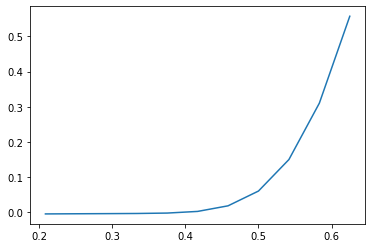

In [53]:
x = scenarios_io_df['arrival_rate']
y = scenarios_io_df['prob_blockedby_pp_q_lm']
plt.plot(x, y)

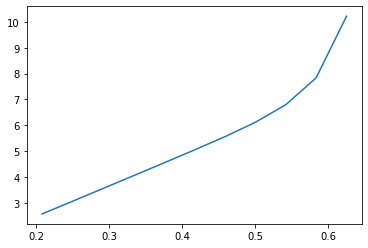

In [54]:
x = scenarios_io_df['arrival_rate']
y = scenarios_io_df['pred_ldr_occ_mean_q_lassocv']
plt.plot(x, y)

## Comparing predicted perf curves to simulation results

* I created a scenario input file: `exp11b_obflow06_metainputs.csv`.
* Create a run settings file `input/exp11b_obflow06_settings.yaml`
* Edit (until I create a CLI) `obsimpy.create_configs.py` by setting experiment suffix. This then creates all the necessary path related variables. Make sure to create the new subdirs in logs and stats with same name as experiment suffix.
* Run `obsimpy.create_configs.py` that takes the scenario input file and run settings as input and then creates:
    - one obsimpy yaml config file for each scenario row
    - a bash script to run each simulation scenario and then runs `obflow_6_output.py` to post process the logs and stats  
    - results in `scenario_siminout_exp11b.csv`
    - we can import this csv file to provide the actual simulation based estimates of all the performance measures.





In [10]:
scenario_siminout_exp11b_df = pd.read_csv(Path(raw_data_path, 'exp11b', 'scenario_siminout_exp11b.csv'), 
                                         index_col=0)

scenario_siminout_exp11c_df = pd.read_csv(Path(raw_data_path, 'exp11c', 'scenario_siminout_exp11c.csv'), 
                                         index_col=0)

X_performance_curves_exp11b_df = pd.read_csv(Path('mm_use', 'X_performance_curves_exp11b.csv'), 
                                         index_col=0)

X_performance_curves_exp11c_df = pd.read_csv(Path('mm_use', 'X_performance_curves_exp11c.csv'), 
                                         index_col=0)

X_performance_curves_exp11d_df = pd.read_csv(Path('mm_use', 'X_performance_curves_exp11d.csv'), 
                                         index_col=0)



NameError: name 'raw_data_path' is not defined

In [56]:
scenario_siminout_exp11b_df.head()

,arrival_rate,mean_los_obs,num_erlang_stages_obs,mean_los_ldr,num_erlang_stages_ldr,mean_los_csect,num_erlang_stages_csect,mean_los_pp_noc,mean_los_pp_c,num_erlang_stages_pp,...,occ_mean_p95_obs,occ_mean_p95_ldr,occ_mean_p95_csect,occ_mean_p95_pp,prob_blockedby_ldr,condmeantime_blockedby_ldr,condp95time_blockedby_ldr,prob_blockedby_pp,condmeantime_blockedby_pp,condp95time_blockedby_pp
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.208333,2.4,1,12,2,1,4,48,72,8,...,2.0,5.033333,0.7,16.966667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.250000,2.4,1,12,2,1,4,48,72,8,...,2.0,6.000000,1.0,19.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.291667,2.4,1,12,2,1,4,48,72,8,...,2.0,7.000000,1.0,22.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.333333,2.4,1,12,2,1,4,48,72,8,...,2.1,7.500000,1.0,25.200000,0.000006,0.026328,0.026328,0.000038,0.322350,0.434922
5,0.375000,2.4,1,12,2,1,4,48,72,8,...,3.0,8.000000,1.0,27.933333,0.000023,0.170990,0.189097,0.000806,2.010838,3.614276


In [57]:
X_performance_curves_exp11b_df.head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,load_pp,...,pred_prob_blockedby_pp_noq_lm,pred_condmeantime_blockedby_pp_noq_lm,pred_ldr_occ_mean_noq_poly,pred_ldr_occ_p95_noq_poly,pred_prob_blockedby_pp_noq_poly,pred_condmeantime_blockedby_pp_noq_poly,pred_pp_occ_mean_basicq_lassocv,pred_pp_occ_p95_basicq_lassocv,pred_pp_occ_mean_noq_poly,pred_pp_occ_p95_noq_poly
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.208333,2.4,12,16,54,0.25,36,2.5,0.15625,11.25,...,-0.046716,2.472909,-0.665824,15.941479,-0.046716,2.472909,11.609760,17.724422,11.224878,19.046791
2,0.250000,2.4,12,16,54,0.25,36,3.0,0.18750,13.50,...,-0.032741,2.909799,0.236588,15.940219,-0.032741,2.909799,13.805848,20.421893,13.489824,21.257198
3,0.291667,2.4,12,16,54,0.25,36,3.5,0.21875,15.75,...,-0.018767,3.346689,1.114218,15.943163,-0.018767,3.346689,16.001935,23.058744,15.751996,23.516365
4,0.333333,2.4,12,16,54,0.25,36,4.0,0.25000,18.00,...,-0.004793,3.783579,1.967067,15.950308,-0.004793,3.783579,18.198022,25.647601,18.011395,25.824291
5,0.375000,2.4,12,16,54,0.25,36,4.5,0.28125,20.25,...,0.009181,4.220469,2.795135,15.961657,0.009181,4.220469,20.394109,28.197235,20.268019,28.180976


In [58]:
performance_curves_exp11b_simout_df = X_performance_curves_exp11b_df.merge(scenario_siminout_exp11b_df, on='scenario', suffixes=[None, '_sim'])
performance_curves_exp11c_simout_df = X_performance_curves_exp11c_df.merge(scenario_siminout_exp11c_df, on='scenario', suffixes=[None, '_sim'])

In [59]:
performance_curves_exp11b_simout_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 94 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   arrival_rate                              11 non-null     float64
 1   mean_los_obs                              11 non-null     float64
 2   mean_los_ldr                              11 non-null     int64  
 3   cap_ldr                                   11 non-null     int64  
 4   mean_los_pp                               11 non-null     int64  
 5   c_sect_prob                               11 non-null     float64
 6   cap_pp                                    11 non-null     int64  
 7   load_ldr                                  11 non-null     float64
 8   rho_ldr                                   11 non-null     float64
 9   load_pp                                   11 non-null     float64
 10  rho_pp                                  

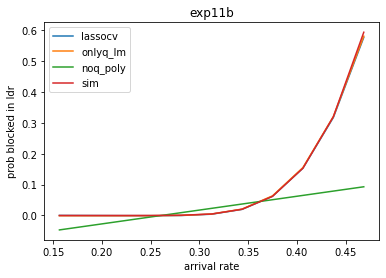

In [60]:
x = performance_curves_exp11b_simout_df['rho_ldr']
y1 = performance_curves_exp11b_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11b_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11b_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11b_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='sim')
plt.title("exp11b")
plt.xlabel('arrival rate')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

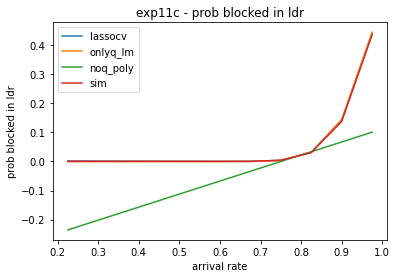

In [61]:
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11c_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='sim')
plt.title("exp11c - prob blocked in ldr")
plt.xlabel('arrival rate')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

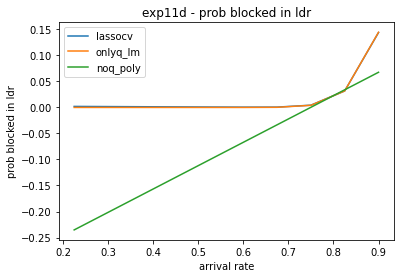

In [78]:
x = X_performance_curves_exp11d_df['rho_ldr']
y1 = X_performance_curves_exp11d_df['pred_prob_blockedby_pp_q_lassocv']
y2 = X_performance_curves_exp11d_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = X_performance_curves_exp11d_df['pred_prob_blockedby_pp_noq_poly']
#y4 = performance_curves_exp11c_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
#plt.plot(x, y4, label='sim')
plt.title("exp11d - prob blocked in ldr")
plt.xlabel('arrival rate')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

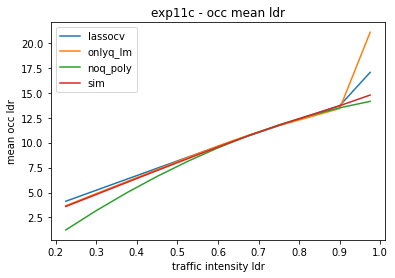

In [62]:
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_poly']
y4 = performance_curves_exp11c_simout_df['occ_mean_mean_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='sim')
plt.title("exp11c - occ mean ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('mean occ ldr')
plt.legend()
plt.show()

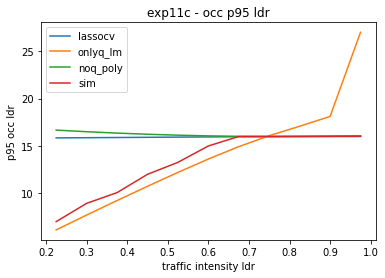

In [63]:
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_noq_poly']
y4 = performance_curves_exp11c_simout_df['occ_mean_p95_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='sim')
plt.title("exp11c - occ p95 ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

I don't understand the plot above. Why is lassocv predicting near capacity for all arrival rates? In original fitting, we had range of rho values and small ldr 95%iles that lassocv predicted very well. However, when I look at the coeffs plot, it looks like capacity has a positive multiplier around 5.0 with no other negative coefficients. How is this possible? If I look at the coeffs dataframe, the coefficient on ldr_cap is 0.99 for each fold. The intercept is 9 and there are no other negative terms. So, how in the world are we getting predictions below 9 (which according to the scatter plot, we are)?!

In [64]:
x = performance_curves_exp11c_simout_df['rho_pp']
y1 = performance_curves_exp11c_simout_df['pred_pp_occ_mean_basicq_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_pp_occ_mean_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_pp_occ_mean_noq_poly']
y4 = performance_curves_exp11c_simout_df['occ_mean_mean_pp']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='sim')
plt.title("exp11c - occ mean pp")
plt.xlabel('traffic intensity pp')
plt.ylabel('mean occ pp')
plt.legend()
plt.show()

KeyError: 'pred_pp_occ_mean_onlyq_lm'

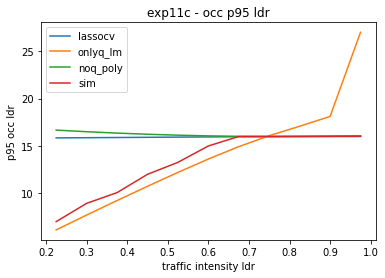

In [65]:
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_noq_poly']
y4 = performance_curves_exp11c_simout_df['occ_mean_p95_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='sim')
plt.title("exp11c - occ p95 ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results'].keys()

In [66]:
ldr_results['ldr_occ_p95_q_lassocv_results']['coeffs_df'].transpose()

,0,1,2,3,4
intercept,9.740741,9.985494,9.786728,9.697222,9.751543
arrival_rate,0.000000,0.028307,0.000000,0.000000,0.000000
mean_los_obs,0.000000,0.000000,0.000000,0.000000,0.000000
mean_los_ldr,0.000000,0.000000,0.000000,0.000000,0.000000
cap_ldr,0.997891,0.996381,0.997384,0.998005,0.998169
mean_los_pp,-0.000000,0.000000,0.000000,-0.000000,-0.000000
c_sect_prob,-0.000000,0.000000,0.000000,-0.000000,-0.000000
cap_pp,0.000000,0.000004,0.000053,0.000025,0.000012
load_ldr,0.000000,0.000000,0.000000,0.000000,0.000000
rho_ldr,0.118982,0.038792,0.104888,0.072102,0.084764


From below, looks like the coefficient plot is on the scaled coefficients. Does this have something to do with scaling? Is the model using scaled or unscaled coefficients? Does the model know it's been scaled? How does it treat new data for predictions?

In [67]:
ldr_results['ldr_occ_p95_q_lassocv_results']['scaled_coeffs_df'].transpose()

,0,1,2,3,4
intercept,9.740741,9.985494,9.786728,9.697222,9.751543
arrival_rate,0.000000,0.009151,0.000000,0.000000,0.000000
mean_los_obs,0.000000,0.000000,0.000000,0.000000,0.000000
mean_los_ldr,0.000000,0.000000,0.000000,0.000000,0.000000
cap_ldr,4.915218,4.834883,4.908283,4.889697,4.827103
mean_los_pp,-0.000000,0.000000,0.000000,-0.000000,-0.000000
c_sect_prob,-0.000000,0.000000,0.000000,-0.000000,-0.000000
cap_pp,0.000000,0.000096,0.001273,0.000589,0.000292
load_ldr,0.000000,0.000000,0.000000,0.000000,0.000000
rho_ldr,0.015534,0.005075,0.014413,0.009567,0.011472


In [68]:
ldr_results['ldr_occ_p95_q_lassocv_results']['predictions']

array([ 3.94103565,  3.94840555,  3.96353967,  2.95254284,  2.96690061,
        2.97923066,  1.98329207,  1.99623192,  2.00886556,  7.98036854,
        7.98963622,  7.99978271,  5.98963274,  6.00327598,  6.01078562,
        5.00266427,  5.02429835,  5.02792042, 10.97882884, 10.99292895,
       11.00103652,  9.98924724, 10.00412362, 10.00847062,  8.99950947,
        9.01360958,  9.02171715, 14.9838875 , 14.99329578, 14.99767371,
       12.993957  , 13.00245266, 13.00908036, 12.00038351, 12.0169321 ,
       12.02301471, 17.982843  , 17.9914939 , 17.99820896, 15.99356763,
       16.00167823, 16.01295396, 14.99908769, 15.01397773, 15.01531336,
        3.95270215,  3.97079934,  3.98693682,  2.96292751,  2.9810247 ,
        2.98804519,  1.97038643,  1.99591365,  2.01480954,  7.95931044,
        7.97920534,  7.99231858,  5.98498214,  5.99738162,  6.00865387,
        4.99920743,  5.01596791,  5.02908965, 10.97588464, 10.99210975,
       10.99661421,  9.98901108,  9.99979059, 10.00836952,  8.99

In [69]:
ldr_results['ldr_occ_p95_q_lm_results']['coeffs_df'].transpose()

,0,1,2,3,4
intercept,1.047773e+01,1.206775e+01,-6.520015e+00,1.427135e+01,1.482387e+02
arrival_rate,-6.940846e+07,-5.579260e+07,-5.549515e+07,-4.615875e+07,-5.666788e+07
mean_los_obs,1.172647e+01,-2.328378e+00,8.852240e+00,1.830213e+00,2.620001e+00
mean_los_ldr,-1.993697e+00,-1.555523e+00,2.334356e+00,1.248433e+00,-1.003989e+01
cap_ldr,1.054636e+00,1.026175e+00,1.045998e+00,1.058833e+00,1.079320e+00
mean_los_pp,-3.398553e-01,2.418340e-01,-8.785142e-01,-6.952968e-01,-7.089083e-01
c_sect_prob,8.674854e+00,-3.691236e+00,2.161722e+01,1.720239e+01,1.770881e+01
cap_pp,1.283078e-02,8.141452e-03,1.064910e-02,9.148386e-03,1.173897e-02
load_ldr,5.784040e+06,4.649384e+06,4.624598e+06,3.846564e+06,4.722325e+06
rho_ldr,5.588476e+00,4.328779e+00,5.456443e+00,4.733054e+00,5.352378e+00


In [70]:
ldr_results['ldr_occ_p95_q_lassocv_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_q_lassocv_coeffs.csv')
ldr_results['ldr_occ_p95_q_lm_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_q_lm_coeffs.csv')
ldr_results['ldr_occ_p95_onlyq_lm_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_onlyq_lm_coeffs.csv')
ldr_results['ldr_occ_p95_q_poly_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_q_poly.csv')
ldr_results['ldr_occ_p95_noq_poly_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_noq_poly.csv')

In [71]:
x = scenarios_io_df['rho_ldr']
y1a = X_performance_curves_df['pred_ldr_occ_p95_q_lm']
y1b = X_performance_curves_df['pred_ldr_occ_p95_q_lassocv']
y2 = X_performance_curves_df['pred_ldr_occ_p95_onlyq_lm']
y3a = X_performance_curves_df['pred_ldr_occ_p95_noq_poly']
y3b = X_performance_curves_df['pred_ldr_occ_p95_noq_lm']
y4 = scenarios_io_df['occ_mean_p95_ldr']
plt.plot(x, y1a, label='q_lm')
plt.plot(x, y1b, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3a, label='noq_poly')
plt.plot(x, y3a, label='noq_lm')
plt.plot(x, y4, label='sim')
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

NameError: name 'X_performance_curves_df' is not defined

Let's add the noq curve that would have been generated. This should be a good test of the "so what?" question. Is it worth it to expend the extra modeling effort to include queueing terms. In addition to prob blocked in ldr, let's do curves for:

* occ mean ldr
* occ p95 ldr
* cond mean wait time in ldr
* occ mean pp
* occ p95 pp



So, why then do nn, rf and svr perform so poorly when all they need to do is discover a single variable regression model (for mean occ using load) or a almost as simple load + z * sqrt(load) model?

## Variable importance in the RF models
This might be interesting to look at. Does it jive with our queueing knowledge?

## Boosted regression trees
Do algos exist in sklearn for these?

## Scratch pad

In [ ]:
'a' + 'b'

In [ ]:
max(0, -2)

In [ ]:
np.arange(.3, 1.4, 0.1).tolist()

In [72]:
mm_experiment_suffix = "exp11"
perf_curve_scenarios_suffix = "exp11d"
path_scenario_grid_yaml = Path("mm_use", f"scenario_grid_{perf_curve_scenarios_suffix}.yaml")
path_scenario_df = Path("mm_use", f"X_performance_curves_{perf_curve_scenarios_suffix}.csv")
raw_data_path = Path("data/siminout")

with open(path_scenario_grid_yaml, "r") as stream:
    try:
        scenario_grid = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

print(scenario_grid)

{'arrival_rate': [0.3, 0.4, 0.5, 0.6000000000000001, 0.7000000000000002, 0.8000000000000003, 0.9000000000000001, 1.0000000000000002, 1.1000000000000003, 1.2000000000000004], 'c_sect_prob': [0.25], 'cap_ldr': [16], 'cap_obs': [1000], 'cap_pp': [75], 'mean_los_csect': [1.0], 'mean_los_ldr': [12.0], 'mean_los_obs': [2.4], 'mean_los_pp_c': [72.0], 'mean_los_pp_noc': [48.0], 'num_erlang_stages_csect': [1], 'num_erlang_stages_ldr': [1], 'num_erlang_stages_obs': [1], 'num_erlang_stages_pp': [1]}


In [74]:
#pd.DataFrame(scenario_grid)

In [424]:
for t in itertools.product([0, 1], [2, 4]):
    print(t)

(0, 2)
(0, 4)
(1, 2)
(1, 4)


In [425]:
for t in itertools.product(*[[0, 1], [2, 4]]):
    print(t)

(0, 2)
(0, 4)
(1, 2)
(1, 4)


In [426]:
[value for key, value in scenario_grid.items()]

[[0.3,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000002,
  0.8000000000000003,
  0.9000000000000001,
  1.0000000000000002,
  1.1000000000000003,
  1.2000000000000004,
  1.3000000000000005],
 [0.25],
 [16],
 [1000],
 [75],
 [1.0],
 [12.0],
 [2.4],
 [72.0],
 [48.0],
 [1],
 [1],
 [1],
 [1]]

In [427]:
for t in itertools.product(*[value for key, value in scenario_grid.items()]):
    print(t)

(0.3, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(0.4, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(0.5, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(0.6000000000000001, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(0.7000000000000002, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(0.8000000000000003, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(0.9000000000000001, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(1.0000000000000002, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(1.1000000000000003, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(1.2000000000000004, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)
(1.3000000000000005, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1)


In [428]:
input_scenarios =  [scn for scn in itertools.product(*[value for key, value in scenario_grid.items()])]
input_scenarios

[(0.3, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1),
 (0.4, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1),
 (0.5, 0.25, 16, 1000, 75, 1.0, 12.0, 2.4, 72.0, 48.0, 1, 1, 1, 1),
 (0.6000000000000001,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (0.7000000000000002,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (0.8000000000000003,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (0.9000000000000001,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (1.0000000000000002,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (1.1000000000000003,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (1.2000000000000004,
  0.25,
  16,
  1000,
  75,
  1.0,
  12.0,
  2.4,
  72.0,
  48.0,
  1,
  1,
  1,
  1),
 (1.3000000000000005,
  0.25,
  1

In [ ]:
input_scenarios = [scn for scn in itertools.product(
    arrival_rate, mean_los_obs, cap_obs, mean_los_ldr, mean_los_csect, cap_ldr,
    mean_los_pp_noc, mean_los_pp_c, c_sect_prob, cap_pp,
    num_erlang_stages_obs, num_erlang_stages_ldr, num_erlang_stages_pp, num_erlang_stages_csect)]

In [ ]:
cols = ['arrival_rate', 'mean_los_obs', 'cap_obs', 'mean_los_ldr', 'mean_los_csect', 'cap_ldr',
        'mean_los_pp_noc', 'mean_los_pp_c', 'c_sect_prob', 'cap_pp',
        'num_erlang_stages_obs', 'num_erlang_stages_ldr',
        'num_erlang_stages_pp', 'num_erlang_stages_csect']